In [40]:
import os
import keras
import numpy as np
import pandas as pd
import jieba.posseg as pseg
from keras import preprocessing
from keras.preprocessing import sequence
from keras.utils.data_utils import pad_sequences
print(os.listdir("./input"))
print(os.listdir("./input/fake-news-pair-classification-challenge"))
print(os.listdir("./input/apply-jieba-tokenizer"))

['apply-jieba-tokenizer', 'fake-news-pair-classification-challenge', 'tokenized_test.csv', 'tokenized_train.csv']
['test.csv', 'train.csv']
['tokenized_test.csv', 'tokenized_train.csv', '__output__.json']


In [41]:
if os.path.isdir("./input/fake-news-pair-classification-challenge"):
    TRAIN_CSV_PATH = './input/fake-news-pair-classification-challenge/train.csv'
    TEST_CSV_PATH = './input/fake-news-pair-classification-challenge/test.csv'
    TOKENIZED_TRAIN_CSV_PATH = "./input/apply-jieba-tokenizer/tokenized_train.csv"
    TOKENIZED_TEST_CSV_PATH = "./input/apply-jieba-tokenizer/tokenized_test.csv"
else:
    TRAIN_CSV_PATH = './input/train.csv'
    TEST_CSV_PATH = './input/test.csv'
    TOKENIZED_TRAIN_CSV_PATH = None
print("Successfully")

Successfully


In [42]:
train = pd.read_csv(TRAIN_CSV_PATH, index_col='id')
train.head(5)

,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
id,,,,,,,
0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


In [43]:
cols = ['title1_zh', 'title2_zh', 'label']
train = train.loc[:, cols]
train.head(5)

,title1_zh,title2_zh,label
id,,,
0,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,unrelated
3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,unrelated
1,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,unrelated
2,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,unrelated
9,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,agreed


In [44]:
text = '2017养老保险又新增两项，农村老人人人可申领，你领到了吗'
words = pseg.cut(text)
[word for word in words]

[pair('2017', 'm'),
 pair('养老保险', 'n'),
 pair('又', 'd'),
 pair('新增', 'v'),
 pair('两项', 'm'),
 pair('，', 'x'),
 pair('农村', 'n'),
 pair('老人', 'n'),
 pair('人人', 'n'),
 pair('可', 'v'),
 pair('申领', 'v'),
 pair('，', 'x'),
 pair('你', 'r'),
 pair('领到', 'v'),
 pair('了', 'ul'),
 pair('吗', 'y')]

In [45]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [46]:
train.isna().any()

title1_zh    False
title2_zh     True
label        False
dtype: bool

In [47]:
train.title2_zh.fillna('UNKNOWN', inplace=True)
train.isna().any()

title1_zh    False
title2_zh    False
label        False
dtype: bool

In [48]:
def process(data):
    res = data.apply(jieba_tokenizer)
    return res

def check_merge_idx(data, res):
    assert((data.index == res.index).all(), 'Something error when merge data')

def parallelize(data, func):
    from multiprocessing import cpu_count, Pool
    cores = partitions = cpu_count()
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    res = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    check_merge_idx(data, res)
    return res

<>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\alex2\AppData\Local\Temp\ipykernel_9820\1844286404.py:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert((data.index == res.index).all(), 'Something error when merge data')


In [49]:
np.all(train.index == train.title1_zh.index)

True

In [50]:
if os.path.exists(TOKENIZED_TRAIN_CSV_PATH):
    print("Use prepared tokenized train data")
    train = pd.read_csv(TOKENIZED_TRAIN_CSV_PATH, index_col='id')
else:
    print("start to training")
    train['title1_tokenized'] = parallelize(train.loc[:, 'title1_zh'], process)
    train['title2_tokenized'] = parallelize(train.loc[:, 'title2_zh'], process)
    train.to_csv('tokenized_train.csv',index=True)
print("Successfully")

Use prepared tokenized train data
Successfully


In [51]:
train.loc[:, ["title1_zh", "title1_tokenized"]].head(10)
train.loc[:, ["title2_zh", "title2_tokenized"]].head(10)

,title2_zh,title2_tokenized
id,,
0,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,警方 辟谣 鸟巢 大会 每人 领 5 万 仍 有 老人 坚持 进京
3,深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,深圳 GDP 首 超 香港 深圳 统计局 辟谣 只是 差距 在 缩小
1,GDP首超香港？深圳澄清：还差一点点……,GDP 首 超 香港 深圳 澄清 还 差 一点点
2,去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,去年 深圳 GDP 首 超 香港 深圳 统计局 辟谣 还 差 611 亿
9,吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,吃 了 30 年 食用油 才 知道 一片 大蒜 轻松 鉴别 地沟油
4,深圳GDP首超香港？统计局辟谣：未超但差距再度缩小,深圳 GDP 首 超 香港 统计局 辟谣 未 超 但 差距 再度 缩小
6,"榴莲不能和什么一起吃 与咖啡同吃诱发心脏病""""",榴莲 不能 和 什么 一起 吃 与 咖啡 同 吃 诱发 心脏病
5,深圳GDP首超香港？辟谣：未超但差距再度缩小,深圳 GDP 首 超 香港 辟谣 未 超 但 差距 再度 缩小
7,咸宁一家店的蛋糕含有“棉花”？崇阳多部门联合辟谣,咸宁 一家 店 的 蛋糕 含有 棉花 崇阳 多 部门 联合 辟谣


In [52]:
train.fillna('UNKNOWN', inplace=True)

In [53]:
MAX_NUM_WORDS = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

In [54]:
corpus_x1 = train.title1_tokenized
corpus_x2 = train.title2_tokenized
corpus = pd.concat([corpus_x1, corpus_x2])
corpus.shape

pd.DataFrame(corpus.iloc[:5], columns=['title'])

corpus.isna().any()

False

In [55]:
tokenizer.fit_on_texts(corpus)
x1_train = tokenizer.texts_to_sequences(corpus_x1)
x2_train = tokenizer.texts_to_sequences(corpus_x2)

In [56]:
len(x1_train)
x1_train[:1]

[[217, 1268, 32, 1178, 5967, 25, 489, 2877, 116, 5559, 4, 1850, 2, 13]]

In [57]:
for seq in x1_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['2017', '养老保险', '又', '新增', '两项', '农村', '老人', '人人', '可', '申领', '你', '领到', '了', '吗']


In [58]:
MAX_SEQUENCE_LENGTH = 20
x1_train = keras.utils.data_utils.pad_sequences(x1_train, maxlen=MAX_SEQUENCE_LENGTH)
x2_train = keras.utils.data_utils.pad_sequences(x2_train, maxlen=MAX_SEQUENCE_LENGTH)

In [59]:
for seq in x1_train + x2_train: assert len(seq) == 20   
print("Length of all assert = 20")

Length of all assert = 20


In [60]:
train.label[:5]

id
0    unrelated
3    unrelated
1    unrelated
2    unrelated
9       agreed
Name: label, dtype: object

In [61]:
label_to_index = {'unrelated': 0, 'agreed': 1, 'disagreed': 2}

# 將分類標籤對應到剛定義的數字
y_train = train.label.apply(lambda x: label_to_index[x])
y_train = np.asarray(y_train).astype('float32')
y_train[:5]

array([0., 0., 0., 0., 1.], dtype=float32)

In [62]:
NUM_CLASSES = 3 # 基本參數設置，有幾個分類
MAX_NUM_WORDS = 10000 # 在語料庫裡有多少詞彙
MAX_SEQUENCE_LENGTH = 20 # 一個標題最長有幾個詞彙
NUM_EMBEDDING_DIM = 256 # 一個詞向量的維度
NUM_LSTM_UNITS = 128 # LSTM 輸出的向量維度

In [63]:
y_train = keras.utils.to_categorical(y_train)
y_train[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [64]:
from sklearn.model_selection import train_test_split

VALIDATION_RATIO = 0.1
RANDOM_STATE = 9527

x1_train, x1_val, x2_train, x2_val, y_train, y_val = train_test_split(x1_train, x2_train, y_train, test_size=VALIDATION_RATIO, random_state=RANDOM_STATE)

In [65]:
print("Training Set")
print("-" * 10)
print(f"x1_train: {x1_train.shape}")
print(f"x2_train: {x2_train.shape}")
print(f"y_train : {y_train.shape}")

print("-" * 10)
print(f"x1_val:   {x1_val.shape}")
print(f"x2_val:   {x2_val.shape}")
print(f"y_val :   {y_val.shape}")
print("-" * 10)
print("Test Set")

Training Set
----------
x1_train: (288496, 20)
x2_train: (288496, 20)
y_train : (288496, 3)
----------
x1_val:   (32056, 20)
x2_val:   (32056, 20)
y_val :   (32056, 3)
----------
Test Set


In [66]:
from keras import Input
from keras.layers import Embedding,LSTM, concatenate, Dense
from keras.models import Model

# 分別定義 2 個新聞標題 A & B 為模型輸入
# 兩個標題都是一個長度為 20 的數字序列
top_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')
bm_input = Input(
    shape=(MAX_SEQUENCE_LENGTH, ), 
    dtype='int32')

# 詞嵌入層
# 經過詞嵌入層的轉換，兩個新聞標題都變成
# 一個詞向量的序列，而每個詞向量的維度
# 為 256
embedding_layer = Embedding(
    MAX_NUM_WORDS, NUM_EMBEDDING_DIM)
top_embedded = embedding_layer(
    top_input)
bm_embedded = embedding_layer(
    bm_input)

# LSTM 層
# 兩個新聞標題經過此層後
# 為一個 128 維度向量
shared_lstm = LSTM(NUM_LSTM_UNITS)
top_output = shared_lstm(top_embedded)
bm_output = shared_lstm(bm_embedded)

# 串接層將兩個新聞標題的結果串接單一向量
# 方便跟全連結層相連
merged = concatenate(
    [top_output, bm_output], 
    axis=-1)

# 全連接層搭配 Softmax Activation
# 可以回傳 3 個成對標題
# 屬於各類別的可能機率
dense =  Dense(
    units=NUM_CLASSES, 
    activation='softmax')
predictions = dense(merged)

# 我們的模型就是將數字序列的輸入，轉換
# 成 3 個分類的機率的所有步驟 / 層的總和
model = Model(
    inputs=[top_input, bm_input], 
    outputs=predictions)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      2560000     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          197120      ['embedding_1[0][0]',      

In [67]:
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot

#plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='LR')
#SVG(model_to_dot(model, rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [68]:
from keras.optimizers import Adam

lr = 1e-3
opt = Adam(lr=lr, decay=lr/50)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\alex2\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [69]:
x1_train[:9527].shape

(9527, 20)

In [70]:
# 決定一次要放多少成對標題給模型訓練
BATCH_SIZE = 250

# 決定模型要看整個訓練資料集幾遍
NUM_EPOCHS = 50

# 實際訓練模型
history = model.fit(
    # 輸入是兩個長度為 20 的數字序列
    x=[x1_train, x2_train], 
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    # 每個 epoch 完後計算驗證資料集
    # 上的 Loss 以及準確度
    validation_data=(
        [x1_val, x2_val], 
        y_val
    ),
    # 每個 epoch 隨機調整訓練資料集
    # 裡頭的數據以讓訓練過程更穩定
    shuffle=True
)

Epoch 1/50
1154/1154 [==============================] - 184s 156ms/step - loss: 0.4439 - accuracy: 0.7929 - val_loss: 0.3882 - val_accuracy: 0.8225
Epoch 2/50
1154/1154 [==============================] - 189s 164ms/step - loss: 0.3511 - accuracy: 0.8424 - val_loss: 0.3681 - val_accuracy: 0.8328
Epoch 3/50
1154/1154 [==============================] - 189s 164ms/step - loss: 0.3114 - accuracy: 0.8621 - val_loss: 0.3634 - val_accuracy: 0.8385
Epoch 4/50
1154/1154 [==============================] - 186s 161ms/step - loss: 0.2800 - accuracy: 0.8778 - val_loss: 0.3620 - val_accuracy: 0.8434
Epoch 5/50
1154/1154 [==============================] - 184s 159ms/step - loss: 0.2527 - accuracy: 0.8905 - val_loss: 0.3730 - val_accuracy: 0.8451
Epoch 6/50
1154/1154 [==============================] - 185s 160ms/step - loss: 0.2278 - accuracy: 0.9015 - val_loss: 0.3746 - val_accuracy: 0.8461
Epoch 7/50
1154/1154 [==============================] - 183s 159ms/step - loss: 0.2063 - accuracy: 0.9122 - val_

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

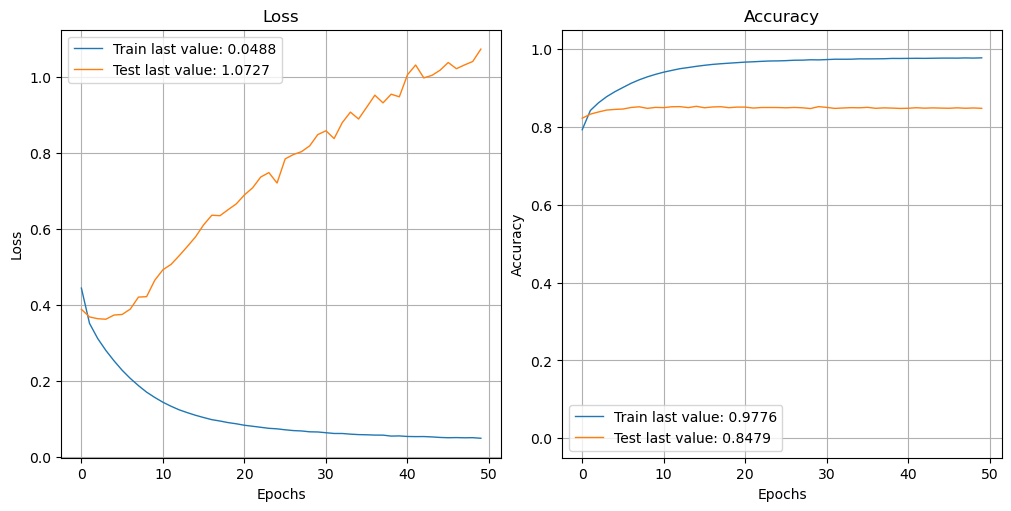

In [71]:
from plot_keras_history import plot_history
plot_history(history)

In [75]:
if os.path.exists(TOKENIZED_TEST_CSV_PATH):
    print("Use tokenized test csv")
    test = pd.read_csv(TOKENIZED_TEST_CSV_PATH, index_col=0)
else:
    print("Use raw test csv")
    test = pd.read_csv(TEST_CSV_PATH, index_col=0)
    test.fillna('UNKNOWN', inplace=True)
    test['title1_tokenized'] = parallelize(test.loc[:, 'title1_zh'], process)
    test['title2_tokenized'] = parallelize(test.loc[:, 'title2_zh'], process)
    test.to_csv('tokenized_test.csv',index=True)
    test.fillna('UNKNOWN', inplace=True)
test.head(3)

Use tokenized test csv


,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,title1_tokenized,title2_tokenized
id,,,,,,,,
321187,167562,59521,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,egypt 's presidential election failed to win m...,Lyon! Lyon officials have denied that Felipe F...,萨拉 赫 人气 爆棚 埃及 总统大选 未 参选 获 百万 选票 现任 总统 压力 山 大,辟谣 里昂 官方 否认 费 基尔 加盟 利物浦 难道 是 价格 没 谈拢
321190,167564,91315,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,A message from Saddam Hussein after he was cap...,The Top 10 Americans believe that the Lizard M...,萨达姆 被捕 后 告诫 美国 的 一句 话 发人深思,10 大 最 让 美国 人 相信 的 荒诞 谣言 如 蜥蜴人 掌控 着 美国
321189,167563,167564,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,Will the United States wage war on Iraq withou...,A message from Saddam Hussein after he was cap...,萨达姆 此项 计划 没有 此国 破坏 的话 美国 还 会 对 伊拉克 发动战争 吗,萨达姆 被捕 后 告诫 美国 的 一句 话 发人深思


In [76]:
x1_test = tokenizer \
    .texts_to_sequences(
        test.title1_tokenized)
x2_test = tokenizer \
    .texts_to_sequences(
        test.title2_tokenized)

# 為數字序列加入 zero padding
x1_test = keras.utils.data_utils.pad_sequences(x1_test, maxlen=MAX_SEQUENCE_LENGTH)
x2_test = keras.utils.data_utils.pad_sequences(x2_test, maxlen=MAX_SEQUENCE_LENGTH)    

# 利用已訓練的模型做預測
predictions = model.predict(
    [x1_test, x2_test])

2504/2504 [==============================] - 42s 16ms/step


In [77]:
predictions[:5]

array([[1.00000000e+00, 3.70318273e-15, 2.17577192e-08],
       [9.99504924e-01, 3.59355080e-12, 4.95048240e-04],
       [9.97851372e-01, 2.14870088e-03, 1.23621988e-10],
       [1.00000000e+00, 1.07423686e-13, 6.69894495e-09],
       [9.99993443e-01, 2.76020873e-10, 6.61294143e-06]], dtype=float32)

In [78]:
index_to_label = {v: k for k, v in label_to_index.items()}

test['Category'] = [index_to_label[idx] for idx in np.argmax(predictions, axis=1)]

submission = test \
    .loc[:, ['Category']] \
    .reset_index()

submission.columns = ['Id', 'Category']
submission.to_csv('submission.csv', index=False)
submission.head()

,Id,Category
0,321187,unrelated
1,321190,unrelated
2,321189,unrelated
3,321193,unrelated
4,321191,unrelated
